In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from cataclop.ml import preprocessing
from cataclop.ml import exploration

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)

from cataclop.ml.pipeline import factories

In [2]:
program = factories.Program.factory('default', version='1.1')

In [3]:
program.train(dataset_params = {
    'from': '2017-01-01',
    'to': '2020-03-01',
    'sub_categories': ['HANDICAP'],
    'countries': ['FRA']
}, model_params = {
    'kfolds': 3,
    'nan_flag': 10000,
    'n_targets': 1
}, dataset_reload=True)

preparing model data
training xgb_10
mea: 0.43031971324826174
training xgb_100
mea: 0.3403290691834683
training ridge_0.1
mea: 12.33102762028761
training ridge_1
mea: 12.252339595559834
training lasso_0.1
mea: 0.34428583295899945
training lasso_1
mea: 0.3443430009651013
training svr
/Users/pourquoi/.local/share/virtualenvs/cataclop-django-M9amAh3O/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
mea: 0.22645208618677973
training knn_1
mea: 0.3383454610731046
training knn_2
mea: 0.3378180354071799
training knn_5
mea: 0.3358709617135767
training knn_10
mea: 0.337415379079833
training mlp_1
/Users/pourquoi/.local/share/virtualenvs/cataclop-django-M9amAh3O/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


In [8]:
program.dataset.players.describe()

,age,earnings,final_odds,final_odds_offline,final_odds_ref,final_odds_ref_offline,final_odds_ref_unibet,final_odds_unibet,handicap_distance,handicap_weight,herder_id,horse_id,jockey_id,num,owner_id,placed_2_count,placed_3_count,placed_count,placed_dividend,placed_earnings,position,post_position,prev_year_earnings,race_count,race_id,trainer_id,victory_count,victory_earnings,winner_dividend,year_earnings,declared_player_count,distance,num_race,num_bis,prize,session_id,hippodrome_id,num_session,hist_1_pos,hist_2_pos,hist_3_pos,hist_4_pos,hist_5_pos,hist_6_pos,speed,win,final_odds_ref_inv,race_count_mean,race_count_std,race_count_amin,race_count_amax,victory_count_mean,victory_count_std,victory_count_amin,victory_count_amax,placed_2_count_mean,placed_2_count_std,placed_2_count_amin,placed_2_count_amax,placed_3_count_mean,placed_3_count_std,placed_3_count_amin,placed_3_count_amax,victory_earnings_mean,victory_earnings_std,victory_earnings_amin,victory_earnings_amax,placed_earnings_mean,placed_earnings_std,placed_earnings_amin,placed_earnings_amax,prev_year_earnings_mean,prev_year_earnings_std,prev_year_earnings_amin,prev_year_earnings_amax,handicap_distance_mean,handicap_distance_std,handicap_distance_amin,handicap_distance_amax,handicap_weight_mean,handicap_weight_std,handicap_weight_amin,handicap_weight_amax,final_odds_ref_mean,final_odds_ref_std,final_odds_ref_amin,final_odds_ref_amax,final_odds_ref_offline_mean,final_odds_ref_offline_std,final_odds_ref_offline_amin,final_odds_ref_offline_amax,race_count_r,victory_count_r,placed_2_count_r,placed_3_count_r,victory_earnings_r,placed_earnings_r,prev_year_earnings_r,handicap_distance_r,handicap_weight_r,final_odds_ref_r,final_odds_ref_offline_r,odds_0,odds_1,odds_2,odds_3,odds_4,odds_5,odds_6,odds_7,odds_8,odds_9,odds_10,odds_11,odds_12,odds_13,odds_14,odds_15,odds_16,odds_17,odds_18,odds_19
count,15050.000000,1.505000e+04,14353.000000,7856.000000,15050.000000,15050.000000,8312.000000,8344.000000,15050.0,15050.000000,11027.000000,15050.000000,15050.000000,15050.000000,15048.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,13306.00000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15044.000000,15050.000000,15050.000000,15050.000000,15050.000000,118.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.0,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.0,15050.0,15050.0,15050.0,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.0,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.00000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000,15050.000000
mean,4.532558,3.518073e+06,19.744074,19.715275,6661.350625,48001.525003,20.104885,20.384732,0.0,29.834751,2425.608506,30317.140532,1265.223256,6.467973,9664.311669,1.890100,1.810963,6.803389,63.190033,12.848955,6.14392,6.466977,9.886908,15.644983,35481.686844,1210.323522,1.832359,13.606225,85.826908,9.656492,11.934219,2003.034551,4.739402,1.389831,9.791380,5156.148771,65.430166,3.970033,3.701595,3.621728,3.585980,3.368904,2.653023,2.313754,0.0,0.084385,0.104743,15.644983,9.310227,4.829502,34.986844,1.832359,1.567864,0.184784,5.069568,1.890100,1.770522,0.101860,5.568173,1.8109

In [7]:
program.model.features

['declared_player_count',
 'final_odds_ref',
 'final_odds_ref_amax',
 'final_odds_ref_amin',
 'final_odds_ref_mean',
 'final_odds_ref_offline',
 'final_odds_ref_offline_amax',
 'final_odds_ref_offline_amin',
 'final_odds_ref_offline_mean',
 'final_odds_ref_offline_r',
 'final_odds_ref_offline_std',
 'final_odds_ref_r',
 'final_odds_ref_std',
 'handicap_distance',
 'handicap_distance_amax',
 'handicap_distance_amin',
 'handicap_distance_mean',
 'handicap_distance_r',
 'handicap_distance_std',
 'handicap_weight',
 'handicap_weight_amax',
 'handicap_weight_amin',
 'handicap_weight_mean',
 'handicap_weight_r',
 'handicap_weight_std',
 'hist_1_pos',
 'hist_2_pos',
 'hist_3_pos',
 'hist_4_pos',
 'hist_5_pos',
 'hist_6_pos',
 'odds_0',
 'odds_1',
 'odds_2',
 'odds_3',
 'odds_4',
 'odds_5',
 'odds_6',
 'odds_7',
 'odds_8',
 'odds_9',
 'placed_2_count',
 'placed_2_count_amax',
 'placed_2_count_amin',
 'placed_2_count_mean',
 'placed_2_count_r',
 'placed_2_count_std',
 'placed_3_count',
 'placed

In [6]:
program.model.models

[{'name': 'xgb_10',
  'steps': [XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
          colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
          max_depth=3, min_child_weight=1, missing=10000, n_estimators=10,
          n_jobs=1, nthread=None, objective='reg:linear', random_state=1234,
          reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
          silent=True, subsample=1)],
  'estimators': [{'pipeline': Pipeline(memory=None,
         steps=[('xgbregressor', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
           colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
           max_depth=3, min_child_weight=1, missing=10000, n_estimators=10,
           n_jobs=1, nthread=None, objective='reg:linear', random_state=1234,
           reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
           silent=True, subsample=1))]),
    'dummies': {'category': ['PLAT', 'STEEPLECHASE', 'HAIE'],
     'sub_

In [ ]:
#program.dataset.save()
#program.model.save()

In [ ]:
#program.lock('2019-02-04')

In [9]:
print(
    '{} races from {} to {}'.format(
        program.df.race_id.nunique(), 
        program.df.start_at.min(), 
        program.df.start_at.max()
    )
)

1258 races from 2017-01-01 15:47:00 to 2020-02-27 17:06:00


In [10]:
for model in program.model.models:
    clf = model['estimators'][-1]['pipeline'].steps[-1][1]
    if hasattr(clf, 'classes_'):
        clf = model['estimators'][-1]['pipeline'].steps[-1][1]
        print(clf.classes_)

In [11]:
pd.set_option('precision',7)
    
for model in program.model.models:
    clf = model['estimators'][-1]['pipeline'].steps[-1][1]
    if hasattr(clf, 'feature_importances_'):
        fi = pd.Series(clf.feature_importances_, index=program.model.features+preprocessing.get_dummy_features(model['estimators'][-1]['dummies']))
        print(model['name'])
        print(fi.sort_values(ascending=False)[0:100])
        print("---\n")
    if hasattr(clf, 'coef_'):
        fi = pd.Series(clf.coef_, index=program.model.features+preprocessing.get_dummy_features(model['estimators'][-1]['dummies']))
        print(model['name'])
        print(fi.sort_values(ascending=False)[0:100])
        print("---\n")

if hasattr(program.model, "stacked_models"):
    for model in program.model.stacked_models:
        clf = model['estimators'][-1]['pipeline'].steps[-1][1]
        if hasattr(clf, 'feature_importances_'):
            fi = pd.Series(clf.feature_importances_, index=program.model.stacked_features+preprocessing.get_dummy_features(model['estimators'][-1]['dummies']))
            print(model['name'])
            print(fi.sort_values(ascending=False)[0:100])
            print("---\n")
        if hasattr(clf, 'coef_'):
            fi = pd.Series(clf.coef_, index=program.model.stacked_features+preprocessing.get_dummy_features(model['estimators'][-1]['dummies']))
            print(model['name'])
            print(fi.sort_values(ascending=False)[0:100])
            print("---\n")
        
pd.set_option('precision',7)



xgb_10
final_odds_ref                 0.2424242
final_odds_ref_r               0.1515152
race_count_r                   0.0909091
prev_year_earnings_r           0.0606061
placed_earnings_r              0.0606061
handicap_weight_amax           0.0454545
final_odds_ref_std             0.0303030
final_odds_ref_amax            0.0303030
final_odds_ref_amin            0.0303030
victory_earnings_r             0.0303030
placed_2_count_r               0.0303030
placed_3_count_r               0.0303030
race_count                     0.0303030
odds_2                         0.0151515
prev_year_earnings             0.0151515
odds_7                         0.0151515
odds_8                         0.0151515
final_odds_ref_offline_amin    0.0151515
final_odds_ref_mean            0.0151515
final_odds_ref_offline         0.0151515
victory_count_r                0.0151515
victory_earnings               0.0151515
handicap_distance              0.0000000
hist_6_pos                     0.0000000
final_odd

In [12]:
df = program.df

for model in program.model.models:
    print(model['name'], df['pred_{}_1'.format(model['name'])].mean())

xgb_10 0.29878951060478876
xgb_100 0.19457303380591803
ridge_0.1 -0.935403714711033
ridge_1 -0.8963211653560363
lasso_0.1 0.19026956152135777
lasso_1 0.19034576814197998
svr 0.02000617954862888
knn_1 0.19304896017836656
knn_2 0.19953893178376333
knn_5 0.19408422120770957
knn_10 0.19427612827045
mlp_1 0.17511398030921946
mlp_10 17.53951584230891
mlp_30 2.0048367220953645
mlp_100 4.824218414219415
rf_10 0.25326141991451534
rf_100 0.25261096508802827


In [13]:
df['pred_sum'] = df[['pred_{}_1'.format(model['name']) for model in program.model.models]].sum(axis=1)
df['pred_sum'] /= len(program.model.models)
#df['pred_sum'] = df['pred_lasso_1_1'] + df['pred_ridge_1_1'] + df['pred_rf_100_1']

In [14]:
cols = [
            'position', 
            'declared_player_count', 
            'sub_category', 
            'num', 
            'final_odds', 
            'final_odds_ref', 
            'final_odds_ref_unibet', 
            'target',
            'pred_sum'
        ] + [
            'pred_{}_1'.format(model['name']) for model in program.model.models
        ] 
exploration.random_race(df, 
                        cols=cols
                       ).sort_values(by='position', ascending=True)

position  declared_player_count sub_category  num  final_odds  \
race_id                                                                       
2657    5093       1.0                     10     HANDICAP    6        10.5   
        5089       2.0                     10     HANDICAP    2        13.9   
        5094       3.0                     10     HANDICAP    7        51.5   
        5088       4.0                     10     HANDICAP    1         1.2   
        5097       5.0                     10     HANDICAP   10       171.9   
        5092       6.0                     10     HANDICAP    5        10.7   
        5096       7.0                     10     HANDICAP    9        51.5   
        5090       8.0                     10     HANDICAP    3        16.1   
        5091       9.0                     10     HANDICAP    4        57.3   
        5095      10.0                     10     HANDICAP    8       171.9   

              final_odds_ref  final_odds_ref_unibet    target   pred_sum  \
race_id                                                                    
2657    5093             4.3                    NaN  2.442347  2.7159308   
        5089             3.9                    NaN  0.000000  2.7292367   
        5094            14.4                    NaN  0.000000  2.7283703   
        5088        100000.0                    NaN  0.000000  2.0470008   
        5097        100000.0                    NaN  0.000000  2.0311824   
        5092             3.2                    NaN  0.000000  2.9213031   
        5096            14.4                    NaN  0.000000  2.8149765   
        5090             4.5                    NaN  0.000000  2.8434917   
        5091        100000.0                    NaN  0.000000  2.0543779   
        5095            48.1                    NaN  0.000000  2.6893942   

              pred_xgb_10_1  pred_xgb_100_1  pred_ridge_0.1_1  pred_ridge_1_1  \
race_id                                                                         
2657    5093      0.3764592       0.2563238         0.2579331       0.2579966   
        5089      0.3874854       0.3381675         0.2736816       0.2737134   
        5094      0.2751564       0.1230437         0.1273693       0.1275106   
        5088      0.2281892       0.0172561         0.0403092       0.0407856   
        5097      0.2281892       0.0712209         0.0424230       0.0428200   
        5092      0.4269976       0.4197756         0.2830492       0.2831440   
        5096      0.2751564       0.2077433         0.3006505       0.3006009   
        5090      0.3879313       0.3459700         0.2152615       0.2154774   
        5091      0.2281892       0.0739622         0.0505510       0.0509685   
        5095      0.2705877       0.1305192         0.2341896       0.2343140   

              pred_lasso_0.1_1  pred_lasso_1_1  pred_svr_1  pred_knn_1_1  \
race_id                                                                    
2657    5093         0.2702328       0.2689224  -0.1643836     0.0000000   
        5089         0.2702343       0.2689238  -0.1644439     0.0000000   
        5094         0.2702101       0.2688999  -0.1642440     0.0000000   
        5088         0.0506570       0.0534130   0.0343010     0.0000000   
        5097         0.0506544       0.0534109   0.0343914     0.0000000   
        5092         0.2702351       0.2689247  -0.1644226     2.1400662   
        5096         0.2702102       0.2688998  -0.1645771     0.0000000   
        5090         0.2702315       0.2689212  -0.1643506     0.0000000   
        5091         0.0506576       0.0534135   0.0343246     0.0000000   
        5095         0.2701356       0.2688271  -0.1641276     0.0000000   

              pred_knn_2_1  pred_knn_5_1  pred_knn_10_1  pred_mlp_1_1  \
race_id                                                                 
2657    5093     0.0000000     0.0000000      0.2140066     0.2377653   
        5089     0.0000000     0.0000000      0

In [15]:
def fast_bet(r):
    idx = r['pred_xgb_100_1'] == r['pred_xgb_100_1'].max()
    #if np.sum(idx) > 1:
    #    r['bet'] = 0
    #    return r
    r['bet'] = (idx).astype('float')
    return r
    
dd = df.groupby('race_id').filter(lambda r: r['pred_sum'].std()!=0)
dd = dd.groupby('race_id').apply(fast_bet)

In [ ]:
#dd['profit'] = df['pred_xgb_10_1'] * 1 * (df['target_returns']-1)
#dd['profit'].describe()

In [20]:
df['pred_rnd'] = np.random.rand(df.shape[0])

#for model in program.model.models:
#    df['pred_minus_ref_{}'.format(model['name'])] = (-df['pred_{}_1'.format(model['name'])]-df['final_odds_ref']).pow(2).pow(0.5)
    
#for model in program.model.stacked_models:
#    df['pred_minus_ref_stacked_{}'.format(model['name'])] = (-df['pred_stacked_{}_1'.format(model['name'])]-df['final_odds_ref']).pow(2).pow(0.5)


In [ ]:
#program.bet(N=1, max_odds=20, targets=['pred_rnd', 'final_odds_ref', 'pred_sum'] + ['pred_{}_1'.format(model['name']) for model in program.model.models])
#bets = program.bets
#bets['profit'].mean()

In [21]:
def bet(df, features, categorical_features, targets, N=1, max_odds=20, break_on_bet=True, break_on_odds=False):

    races = df.sort_values('start_at').groupby('race_id')

    bets = []

    for (id, race) in races:

        candidate_bets = []

        nums = []

        for target in targets:

            r = race.sort_values(by=target, ascending=False)

            if len(r) <= N:
                break
                
            NN = N

            for n in range(NN):

                player = r.iloc[n]

                odds = player['final_odds_ref']

                if max_odds is not None and odds > max_odds:
                    if break_on_odds:
                        break
                    else:
                        continue

                nth = (r['final_odds_ref']<odds).sum()+1
                
                #bet = np.clip(np.abs(player[target])/100.0, 0, 10)
                
                #bet = np.round(1+bet) * 1.5
                
                #if bet <= 0:
                #    break
                
                #if n+1 < len(r) and r.iloc[n+1][target] == player[target]:
                #    NN = NN+1
                    
                bet = 1

                profit = player['winner_dividend']/100.0 * bet - bet
                profit_placed = player['placed_dividend']/100.0 * bet - bet

                row = [id, player['start_at'], player['num'], player['position'], n, odds, player['final_odds'], target, player[target], r[target].std(), bet, profit, profit_placed]

                for nn in range(1,4):
                    if n+nn < len(r):
                        row.append(r.iloc[n+nn][target])
                    else:
                        row.append(np.nan)

                for f in features:
                    row.append(player[f])
                for f in categorical_features:
                    row.append(player[f])

                candidate_bets.append( row )

                nums.append(player['num'])

                if break_on_bet:
                    break

        #if len(candidate_bets) == 1:
        #    bets += candidate_bets
        bets += candidate_bets

    cols = ['id', 'date', 'num', 'pos', 'nb', 'odds_ref', 'odds_final', 'target', 'pred', 'pred_std', 'bet', 'profit', 'profit_placed']

    for nn in range(1,4):
        cols.append('next_pred_{}'.format(nn))

    cols = cols + features + categorical_features

    bets = pd.DataFrame(bets, columns=cols)
    bets['date'] = pd.to_datetime(bets['date'])

    bets = bets.set_index(bets['date'])
    bets = bets.sort_index()

    bets['bets'] = bets['bet'].cumsum()
    bets['stash'] = bets['profit'].cumsum()

    return bets



In [38]:

bets = bet(df, program.model.features, program.model.categorical_features, 
    N=3, max_odds=30, break_on_bet=True, break_on_odds=False, 
    targets=['pred_rnd', 'final_odds_ref', 'pred_sum'] + ['pred_{}_{}'.format(model['name'], i+1) for i in range(program.model.params['n_targets']) for model in program.model.models]# + ['pred_stacked_{}_1'.format(model['name']) for model in program.model.stacked_models] 
   )
    

In [35]:
df[['pred_{}_1'.format(model['name']) for model in program.model.models]].describe()

,pred_xgb_10_1,pred_xgb_100_1,pred_ridge_0.1_1,pred_ridge_1_1,pred_lasso_0.1_1,pred_lasso_1_1,pred_svr_1,pred_knn_1_1,pred_knn_2_1,pred_knn_5_1,pred_knn_10_1,pred_mlp_1_1,pred_mlp_10_1,pred_mlp_30_1,pred_mlp_100_1,pred_rf_10_1,pred_rf_100_1
count,14074.0000000,14074.0000000,14074.0000000,14074.0000000,14074.0000000,14074.0000000,14074.0000000,14074.0000000,14074.0000000,14074.0000000,14074.0000000,14074.0000000,14074.0000000,14074.0000000,14074.0000000,14074.0000000,14074.0000000
mean,0.2987895,0.1945730,-0.9354037,-0.8963212,0.1902696,0.1903458,0.0200062,0.1930490,0.1995389,0.1940842,0.1942761,0.1751140,17.5395158,2.0048367,4.8242184,0.2532614,0.2526110
std,0.0546889,0.1217312,133.9786388,133.6457741,0.0524751,0.0510575,0.3550533,0.6345717,0.4482436,0.2693071,0.1870628,2.0870961,686.6624339,504.9604766,376.5252249,0.2900401,0.1928262
min,0.1915871,-0.1398598,-4545.3109641,-4543.4663826,-0.0606907,-0.0525311,-4.7800855,0.0000000,0.0000000,0.0000000,0.0000000,-87.5516643,-8144.8344314,-6330.0089515,-10985.2755778,0.0000000,0.0000000
25%,0.2705877,0.1243947,0.1496857,0.1497237,0.1790154,0.1794578,-0.0001853,0.0000000,0.0000000,0.0000000,0.0000000,0.2274491,-0.8002620,-0.4024782,-0.1036508,0.0000000,0.1089346
50%,0.2906101,0.1788604,0.1933571,0.1933328,0.1839884,0.1840714,-0.0000192,0.0000000,0.0000000,0.0000000,0.1902108,0.2357776,-0.1211490,0.1083021,0.2730498,0.2091864,0.2192166
75%,0.3222333,0.2460508,0.2387489,0.2386948,0.1848134,0.1847489,0.0001062,0.0000000,0.0000000,0.4002960,0.3077312,0.2377653,0.5283830,0.5010268,0.8908767,0.4114147,0.3571172
max,1.4198225,2.8106380,3756.6394914,3755.8951414,0.6319050,0.6076011,6.4988612,4.8559289,3.5584649,1.8025683,1.2722439,0.2377653,13480.1045269,13935.7727313,4660.1421798,3.1196691,2.6025439


In [36]:
bets = bets.set_index(bets['date'])
bets = bets.sort_index()

In [48]:
list(bets.columns)

['id',
 'date',
 'num',
 'pos',
 'nb',
 'odds_ref',
 'odds_final',
 'target',
 'pred',
 'pred_std',
 'bet',
 'profit',
 'profit_placed',
 'next_pred_1',
 'next_pred_2',
 'next_pred_3',
 'declared_player_count',
 'final_odds_ref',
 'final_odds_ref_amax',
 'final_odds_ref_amin',
 'final_odds_ref_mean',
 'final_odds_ref_offline',
 'final_odds_ref_offline_amax',
 'final_odds_ref_offline_amin',
 'final_odds_ref_offline_mean',
 'final_odds_ref_offline_r',
 'final_odds_ref_offline_std',
 'final_odds_ref_r',
 'final_odds_ref_std',
 'handicap_distance',
 'handicap_distance_amax',
 'handicap_distance_amin',
 'handicap_distance_mean',
 'handicap_distance_r',
 'handicap_distance_std',
 'handicap_weight',
 'handicap_weight_amax',
 'handicap_weight_amin',
 'handicap_weight_mean',
 'handicap_weight_r',
 'handicap_weight_std',
 'hist_1_pos',
 'hist_2_pos',
 'hist_3_pos',
 'hist_4_pos',
 'hist_5_pos',
 'hist_6_pos',
 'odds_0',
 'odds_1',
 'odds_2',
 'odds_3',
 'odds_4',
 'odds_5',
 'odds_6',
 'odds_7',

In [25]:
def graph_bb(bb, f):
    results = []

    for s in bb[f].value_counts().index:
        results = []
        x = bb[ (bb[f] == s) & (bb['pred_std'] != 0) & (bb['pred'] != 0) ].copy()
        if len(x) == 0:
            continue
        #print("---\n{}\t{:+.2f}\t{:+.2f}\t{:+.2f}\n---".format(s, x['profit'].sum(), x['bet'].sum(), len(x)))

        fig, axs = plt.subplots(1,1)

        for t in x['target'].value_counts().index:
            bbb = x[(x['target'] == t)].copy()
            #bbb = bbb[ (bbb['pred']>bbb['pred'].quantile(0.85)) ].copy()


            results.append({
                'idx_1': s,
                'idx_2': t,
                'profit': bbb.profit.sum(),
                'profit_place': bbb.profit_placed.sum(),
                'bet': bbb.bet.sum(),
                'bets': bbb.bet.count(),
                'avg': bbb.profit.sum() / bbb.bet.sum()
            })

            '''
            bbb['stash'] = bbb['profit'].cumsum()
            bbb['cbet'] = bbb['bet'].cumsum()

            fig, axs = plt.subplots(1,1)
            bbb['stash'].plot(figsize=(6, 2))
            bbb['cbet'].plot(figsize=(6, 2))
            plt.show()
            '''

            #print("{:10s}: \t {:+.2f} \t {:+.0f} \t {:+.2f}".format(t, bbb.profit.sum(), bbb.profit.count(), bbb.profit.mean()) )

            bbb['stash'] = bbb['profit'].cumsum()
            bbb['cbet'] = bbb['bet'].cumsum()

            bbb['stash'].plot(figsize=(10, 2))
            bbb['cbet'].plot(figsize=(10, 2))

        results = pd.DataFrame(results)
        results = results.set_index(['idx_1', 'idx_2'])
        print(results.sort_values(by='avg', ascending=False))


        plt.show()
        

In [ ]:
countries = list(bets['country'].value_counts()[0:10].index)
sub_categories = list(bets['sub_category'].value_counts()[0:10].index)

%store countries
%store sub_categories

In [ ]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args

target = 'pred_knn_1_1'

c_min = bets[(bets['target'] == target)]['pred'].min()
c_mean = bets[(bets['target'] == target)]['pred'].mean()
c_max = bets[(bets['target'] == target)]['pred'].max()

space = [
          Real(1, 10, name='min_odds'),
          Real(10, 60, name='max_odds'),
          Real(c_min, c_mean, name='min_pred'),
          Real(c_mean, c_max, name='max_pred'),
          Integer(5, 25, name='max_players')] + [
          Integer(0,1, name='country_{}'.format(country)) for country in countries] + [
          Integer(0,1, name='sub_category_{}'.format(sub_category)) for sub_category in sub_categories] + [
          Integer(0,1, name='nb_{}'.format(n)) for n in range(0,6)]
         
def x_to_params(x):
    params = {}
    
    params['min_odds'] = x[0]
    params['max_odds'] = x[1]
    params['max_pred'] = x[3]
    params['min_pred'] = x[2]
    params['max_players'] = x[4]
    
    for i, country in enumerate(countries):
        params['country_{}'.format(country)] = x[5+i]
        
    for i, sc in enumerate(sub_categories):
        params['sub_category_{}'.format(sc)] = x[5+len(countries)+i]
        
    for n in range(0,6):
        params['nb_{}'.format(n)] = x[5+len(countries)+len(sub_categories)+n]

    return params

@use_named_args(space)
def f(**params):
    return ff(params)
    
def ff(params, train=True):
    
    print(params)
    
    b = bets[ (bets['pred'] != 0) & (bets['target']==target) & (bets['pred_std'] != 0)]
    
    b = b[ (b['odds_ref'] > params['min_odds']) & (b['odds_ref'] < params['max_odds']) & (b['declared_player_count'] > 1) & (b['declared_player_count'] <= params['max_players']) ]
    
    #b = b[(b['pred'] >= params['min_pred']) & (b['pred'] <= params['max_pred'])]
    
    for country in countries:
        if params['country_{}'.format(country)] == 0:
            b = b[ b['country'] != country ]
            
    for sub_category in sub_categories:
        if params['sub_category_{}'.format(sub_category)] == 0:
            b = b[ b['sub_category'] != sub_category ]
            
    for n in range(0,6):
        if params['nb_{}'.format(n)] == 0:
            b = b[ b['nb'] != n]
    
    p = b.profit.sum()
    pp = len(b[b['profit'] > 0])
    bet = b.bet.sum()
    
    print("{:+.2f} {:+.2f}\n".format(p, bet))
        
    if bet == 0:
        return 0
    
    if not train:
        return b
    
    return - (p)
    
    

In [ ]:
#c_mean, c_min, c_max

In [ ]:
#from skopt import dummy_minimize, gp_minimize, gbrt_minimize

#res = dummy_minimize(f, space, n_calls=500)

In [ ]:
#x_to_params(res.x), res.fun

In [ ]:
#params = x_to_params(res.x)
#%store params
#params

In [ ]:
#%store -r params
#%store -r countries
#%store -r sub_categories

In [ ]:
#bb = ff(params, False)

                               avg  bet  bets  profit  profit_place
idx_1    idx_2                                                     
HANDICAP final_odds_ref  0.9345528  246   246   229.9         -20.4


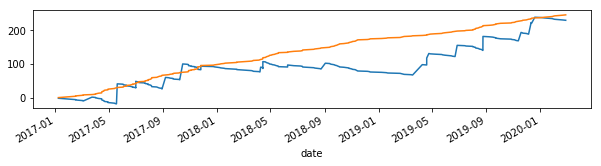

In [66]:
bb = bets[(bets['hist_1_pos'] == 6) | (bets['hist_2_pos'] == 6) | (bets['hist_3_pos'] == 6)]

graph_bb( bb[(bb['target']=='final_odds_ref')], 'sub_category')